# Optimization Algorithms

Until now we have used stochastic gradient descent for optimizing neural networks. 
On the upside, it is easy to implement and circumvents the need to compute a gradient on the full dataset.
It has a few downsides, though.

## Condition number

Consider the following optimization problem:


<img src="high-condition-number-ellipsis.png" alt="High condition number" width="600"/>

- In the first dimension, variance is low.
- In the second dimension, variance is high.

This happens when e.g. we have an optimization problem where units have values in different ranges. For example it could be that any change in weights in early layers in a neural network influences final results less than a change of the same magnitude in a layer near the end.

Mathematically, the Hessian matrix has large **condition number**, i.e. ratio of largest divided by smallest eigenvalue.

For (stochastic) gradient descent this means that we have to choose a step size is very small, such that the algorithm converges for the second dimension, which will make progress slow.
Alternative, we get oscillation along the first axis.

<img src="high-condition-number-ellipsis-sgd.png" alt="High condition number gradient descent" width="600"/>

## Local Minima

In case our loss has a local minimum, SGD will notice that our function has zero gradient and will get stuck.

<img src="local-minimum.png" alt="Local minimum" width="600"/>

Dito for saddle points.

<img src="saddle-point.png" alt="Saddle point" width="600"/>

## Optimization Code

For later development, we will encapsulate our optimizer, as also done in pytorch, in a class. Optimizing a simple resnet on CIFAR-10 can be written as follows.

Check [here](https://pytorch.org/docs/stable/optim.html) for documentation on how to write an optimizer.

In [24]:
# possibly install pytorch via
# 1) conda install pytorch torchvision -c pytorch
# or 2) pip install torch torchvision 
import math
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)


cuda


In [25]:
# class for optimizer. Must implement zero_grad and step

class SGD:
    def __init__(self, model_params, lr=1e-3, weight_decay=0.0):
        self.model_params = list(model_params)
        self.lr = lr
        self.weight_decay = weight_decay

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad + self.lr * self.weight_decay * param.data)

In [26]:
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Example usage
for images, labels in trainloader:
    print(images.shape, labels.shape)
    break

Files already downloaded and verified
Files already downloaded and verified
torch.Size([32, 3, 32, 32]) torch.Size([32])


In [27]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [28]:
def validate(model, dataloader):
    # store model mode and set back to original mode after validation
    model_mode = model.training
    model.eval()
    correct_predictions = 0
    
    for data, target in dataloader:
        data = data.to(device)
        target = target.to(device)
        # Forward pass
        y_pred = model(data)
            
        # Get the predicted class (assuming y_pred is a Tensor with probabilities)
        predicted_class = torch.argmax(y_pred.data, dim=1)
            
        # Check if the prediction is correct
        correct_predictions += (predicted_class == target).sum().item()
            
    
    # Calculate accuracy
    accuracy = correct_predictions / len(dataloader.dataset)
    model.train(model_mode)
    return accuracy

def train(model, optimizer, num_epochs=10):
    val_acc = validate(model, testloader)
    train_acc = validate(model, trainloader)
    model.train()
    print(f"Before training: validation accuracy: {val_acc}")

    # Training loop
    losses = []
    val_accs = []
    train_accs = []

    for epoch in range(num_epochs):
        loss = 0.0
        
        model.train()
        for data, target in trainloader:
            data = data.to(device)
            target = target.to(device)
            # Forward pass
            preds = model(data)
            
            # Loss calculation
            mb_loss = mb_loss = F.cross_entropy(preds, target=target)
            loss += mb_loss.item() * data.shape[0] / len(trainloader.dataset)

            ### ZERO GRAD ###
            optimizer.zero_grad()
            # backward pass
            mb_loss.backward()
        
            # The weight update
            optimizer.step()

        losses.append(loss)
        val_acc = validate(model, testloader)
        val_accs.append(val_acc)
        train_acc = validate(model, trainloader)
        model.train()
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, Loss: {loss}, validation accuracy: {val_acc}, train accuracy: {train_acc}")

    return losses, val_accs, train_accs

In [29]:
# Globally set wd
wd = 0.001

In [30]:
model = ResNet9(3, 10).to(device)
run_name_sgd = "SGD lr=0.01 weight_decay=0.01"
train_losses_sgd, val_accs_sgd, train_accs_sgd = train(model, SGD(model.parameters(), lr=0.01, weight_decay=wd), num_epochs=15)

Before training: validation accuracy: 0.1051
Epoch 1, Loss: 1.7085731434631386, validation accuracy: 0.4387, train accuracy: 0.4417
Epoch 2, Loss: 0.983252693643569, validation accuracy: 0.7368, train accuracy: 0.77064
Epoch 3, Loss: 0.714376099777222, validation accuracy: 0.6898, train accuracy: 0.73146
Epoch 4, Loss: 0.5479465853786472, validation accuracy: 0.7384, train accuracy: 0.8024
Epoch 5, Loss: 0.4166742061805719, validation accuracy: 0.8126, train accuracy: 0.90588
Epoch 6, Loss: 0.3097425847005843, validation accuracy: 0.8018, train accuracy: 0.89816
Epoch 7, Loss: 0.20361272046566037, validation accuracy: 0.7032, train accuracy: 0.80612
Epoch 8, Loss: 0.12258122112751008, validation accuracy: 0.7603, train accuracy: 0.89484
Epoch 9, Loss: 0.06157469186291104, validation accuracy: 0.825, train accuracy: 0.96932
Epoch 10, Loss: 0.025934339032471204, validation accuracy: 0.8524, train accuracy: 0.99396
Epoch 11, Loss: 0.010885844917520902, validation accuracy: 0.8713, train a

In [31]:
# Plot train loss and val accuracy

def plot_train(train_losses_list, val_accs_list, run_names):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot multiple training losses
    for i, train_losses, run_name in zip(range(len(train_losses_list)), train_losses_list, run_names):
        color = f'C{i}'  # Use different colors for each training run
        ax1.plot(train_losses, label=f"{run_name}", color=color)
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    ax2.set_ylabel('Validation Accuracy', color=color)  # we already handled the x-label with ax1
    for i, val_accs in enumerate(val_accs_list):
        color = f'C{i}'
        ax2.plot(val_accs, label="Validation Accuracy", color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.legend(loc='upper right')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Loss and Validation Accuracy')
    plt.show()

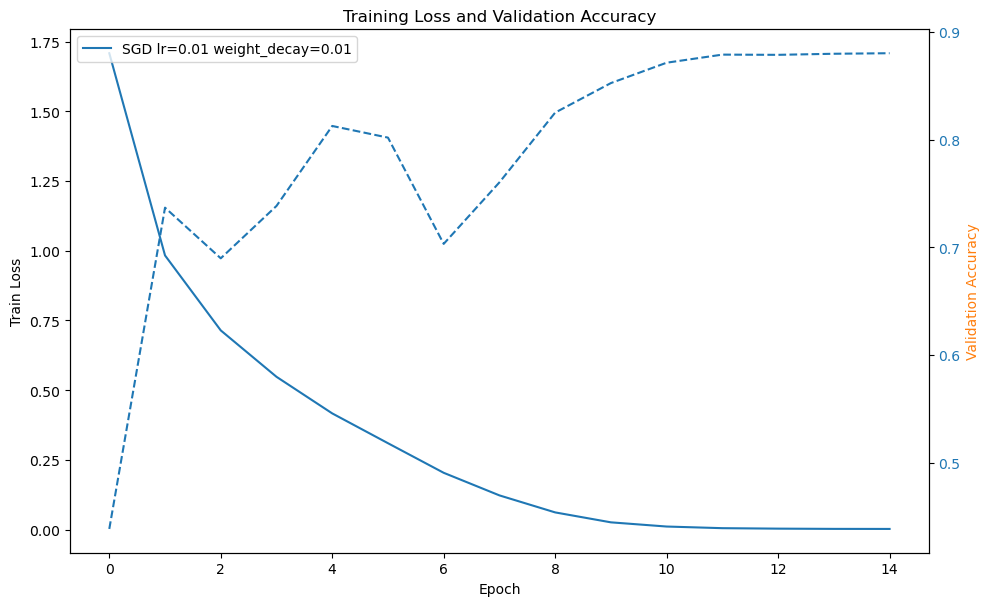

In [32]:
plot_train([train_losses_sgd], [val_accs_sgd], [run_name_sgd])

## Synthetic Functions

We will test our algorithms also on synthetic functions.

### One-dimensional with two minima

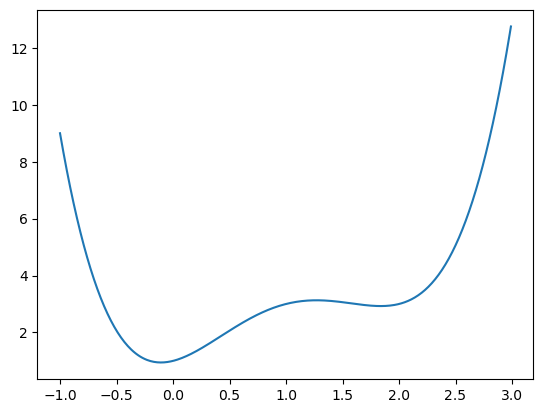

In [33]:
# Let us also try the optimizers on a few simple functions

def poly(x):
    #return 0.051*x**4 -x**3 + 10*x**2 + x
    return x**4 - 4*x**3 + 4*x**2 + 1*x + 1

y = np.arange(-1, 3, 0.01)
x = poly(y)
plt.plot(y, x)

In [34]:
def optimize_1d(f, x, optimizer, nr_steps=50):
    x_values = [x.item()]
    for _ in range(nr_steps):
        optimizer.zero_grad()
        y_pred = f(x)
        y_pred.backward()
        optimizer.step()
        x_values.append(x.item())
    return np.array(x_values)

In [35]:
x = torch.tensor([3.0], requires_grad=True)
optimizer = SGD([x], lr=0.01)
x_values = optimize_1d(poly, x, optimizer, nr_steps=20)

In [36]:
def show_iterations_1d(f, x_min, x_max, x_values):
    x = np.arange(x_min, x_max, 0.01)
    y = f(x)
    y_values = f(x_values)
    plt.plot(x, y)
    plt.scatter(x_values, y_values, c='blue', label='Optimization Path')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Optimization of Scalar Function with Two Local Minima')
    plt.legend()
    plt.show()

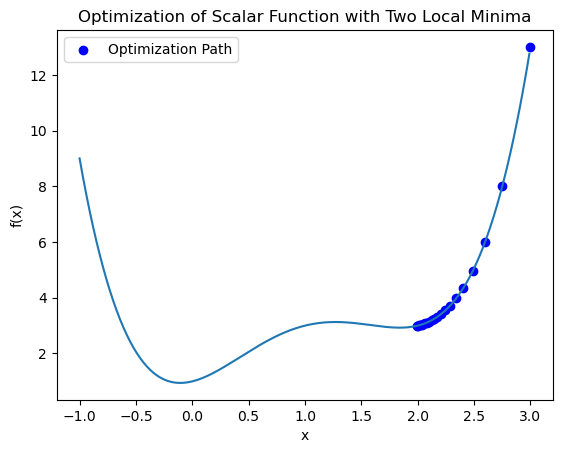

In [37]:
show_iterations_1d(poly, -1, 3, x_values)

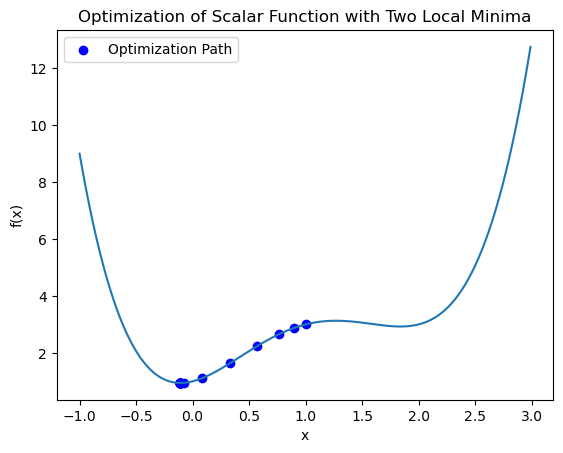

In [38]:
x = torch.tensor([1.0], requires_grad=True)
optimizer = SGD([x], lr=0.1)
x_values = optimize_1d(poly, x, optimizer, nr_steps=50)
show_iterations_1d(poly, -1, 3, x_values)

## Two-dimensional quadratic with high condition number

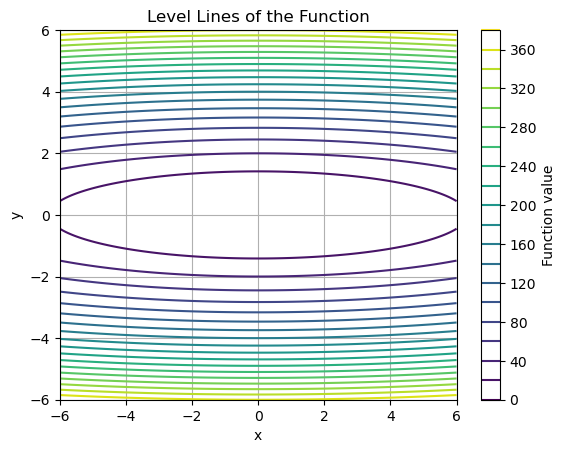

In [39]:
# See what happens on two-dimensional high-condition quadratic function

def quadratic(x):
    return 0.5*x[0]**2 + 10*x[1]**2

def plot_level_lines_2d(f):
    # Generate a grid of points
    x = np.linspace(-6, 6, 400)
    y = np.linspace(-6, 6, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(np.stack([X, Y], axis=0))

    # Plot the level lines (contour lines)
    plt.contour(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Function value')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Level Lines of the Function')
    plt.grid(True)

plot_level_lines_2d(quadratic)


In [40]:
def optimize_2d(f, x, optimizer, nr_steps=50):
    x_values = [x.clone()]
    for _ in range(nr_steps):
        optimizer.zero_grad()
        y_pred = f(x)
        y_pred.backward()
        optimizer.step()
        x_values.append(x.clone())
    return x_values

x = torch.tensor([-5.0,-3.0], requires_grad=True)
optimizer = SGD([x], lr=0.09)
x_values = optimize_2d(quadratic, x, optimizer)

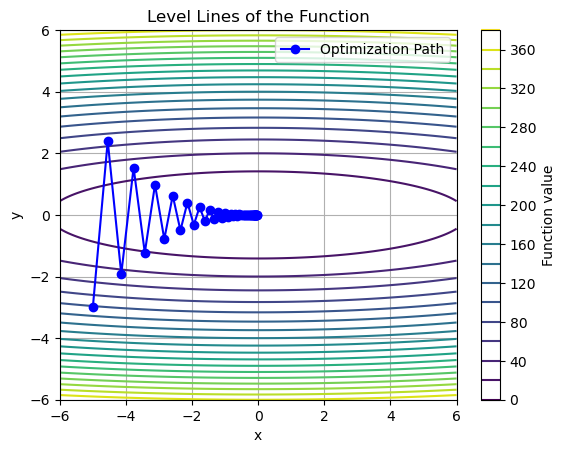

In [41]:
def plot_optimizer_2d(f, x_values):
    plot_level_lines_2d(f)
    x_coords = [x[0].item() for x in x_values]
    y_coords = [x[1].item() for x in x_values]
    plt.plot(x_coords, y_coords, 'o-', c='blue', label='Optimization Path')
    plt.legend()

plot_optimizer_2d(quadratic, x_values)  

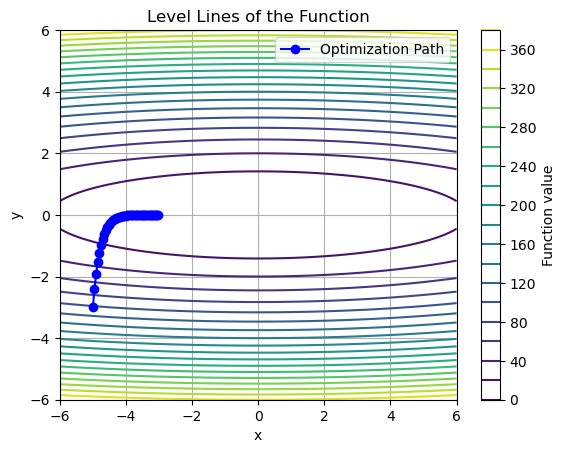

In [42]:
# Lower learning rate
x = torch.tensor([-5.0,-3.0], requires_grad=True)
optimizer = SGD([x], lr=0.01)
x_values = optimize_2d(quadratic, x, optimizer)
plot_optimizer_2d(quadratic, x_values)  

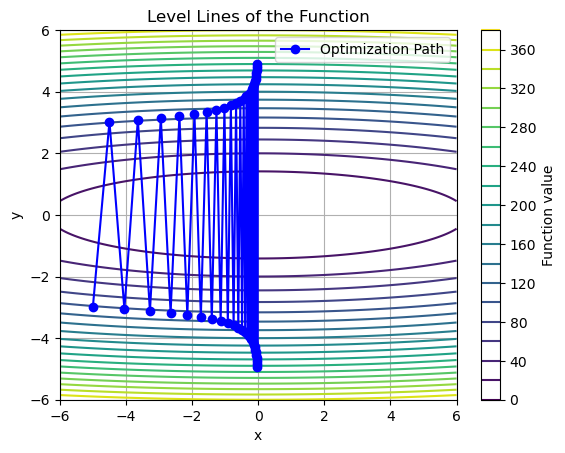

In [43]:
# Higher learning rate
x = torch.tensor([-5.0,-3.0], requires_grad=True)
optimizer = SGD([x], lr=0.1005)
x_values = optimize_2d(quadratic, x, optimizer)
plot_optimizer_2d(quadratic, x_values)  

## Momentum

We will first look into overcoming local minima better. For this, we will use the momentum obtained by our optimization history to roll over some local minima.

In detail:
- Keep exponential moving average of previous gradients to build up a velocity as a running mean of gradients.
- $\rho$ is the parameter for EMA and can be interpreted as the friction (typically $\rho \in [0.9,0.99]$)

Mathematically, GD gives the update equation

$$
\theta^{t+1} = \theta^t - \alpha \nabla \mathcal{L}(\theta^t)
$$

GD with momentum gives

$$
\begin{aligned}
v^t  & = \rho v^t + \nabla \mathcal{L}(\theta^t) \\
\theta^{t+1} & = \theta^t - \alpha v^{t+1}
\end{aligned}
$$

Geometrically, the momentum update looks like

<img src="momentum-geometric-illustration.png" alt="Momentum update geometrically" width="600"/>

We hope that momentum will take us out of some local minima and saddle points.

<img src="momentum-local-minima-saddle-points.png" alt="momentum on saddle points and local minima" width="600"/>

In [44]:
class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9, weight_decay=0.0):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad + self.weight_decay * param.data)
            param -= self.lr * v

In [45]:
model_momentum = ResNet9(3, 10).to(device)
run_name_momentum = "SGD lr=0.001 wd=0.0001 momentum=0.9"
train_losses_momentum, val_accs_momentum, train_accs_momentum =train(model_momentum, SGDMomentum(model_momentum.parameters(), lr=0.001, momentum=0.9, weight_decay=wd), num_epochs=15)

Before training: validation accuracy: 0.1
Epoch 1, Loss: 1.2551575022697448, validation accuracy: 0.686, train accuracy: 0.73452
Epoch 2, Loss: 0.7509806126499183, validation accuracy: 0.7371, train accuracy: 0.79
Epoch 3, Loss: 0.5258768442773811, validation accuracy: 0.8008, train accuracy: 0.88602
Epoch 4, Loss: 0.38061813475370493, validation accuracy: 0.8025, train accuracy: 0.90502
Epoch 5, Loss: 0.2397698678672313, validation accuracy: 0.7888, train accuracy: 0.90748
Epoch 6, Loss: 0.13558804279565803, validation accuracy: 0.8155, train accuracy: 0.96602
Epoch 7, Loss: 0.06106485979914669, validation accuracy: 0.8525, train accuracy: 0.99702
Epoch 8, Loss: 0.021954688304513675, validation accuracy: 0.854, train accuracy: 0.99952
Epoch 9, Loss: 0.009231837617084388, validation accuracy: 0.867, train accuracy: 1.0
Epoch 10, Loss: 0.004612475705109535, validation accuracy: 0.8697, train accuracy: 1.0
Epoch 11, Loss: 0.0031783336449414524, validation accuracy: 0.8715, train accuracy

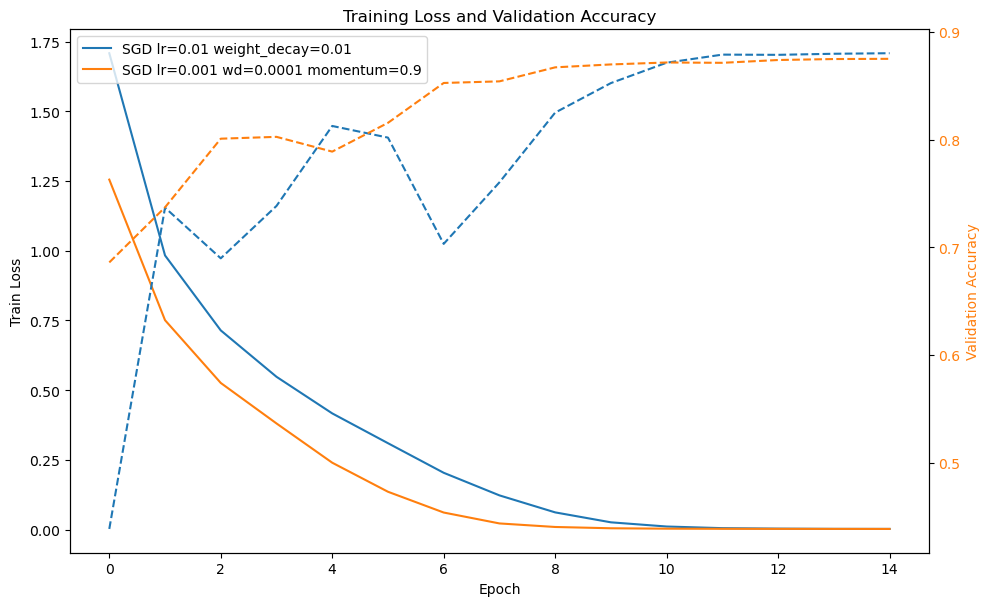

In [46]:
train_losses_list = [train_losses_sgd, train_losses_momentum]
val_accs_list = [val_accs_sgd, val_accs_momentum]
run_names = [run_name_sgd, run_name_momentum]
plot_train(train_losses_list, val_accs_list, run_names)

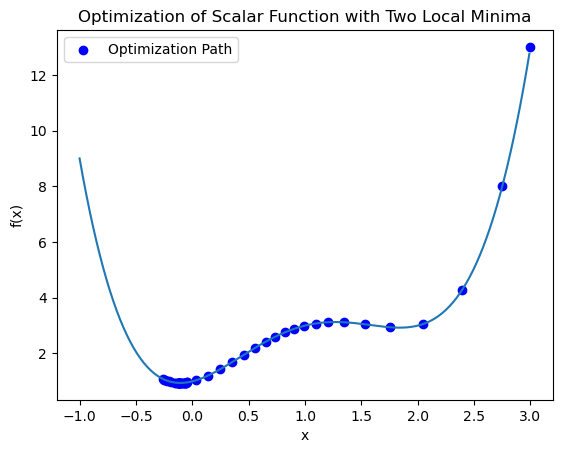

In [47]:
# Let us check on the simple function

x = torch.tensor([3.0], requires_grad=True)
optimizer = SGDMomentum([x], lr=0.01, momentum=0.8)
x_values = optimize_1d(poly, x, optimizer)
show_iterations_1d(poly, -1, 3, x_values)

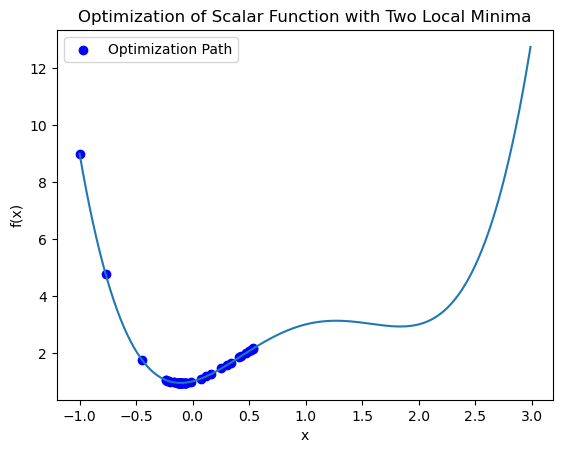

In [48]:
x = torch.tensor([-1.0], requires_grad=True)
optimizer = SGDMomentum([x], lr=0.01, momentum=0.8)
x_values = optimize_1d(poly, x, optimizer)
show_iterations_1d(poly, -1, 3, x_values)

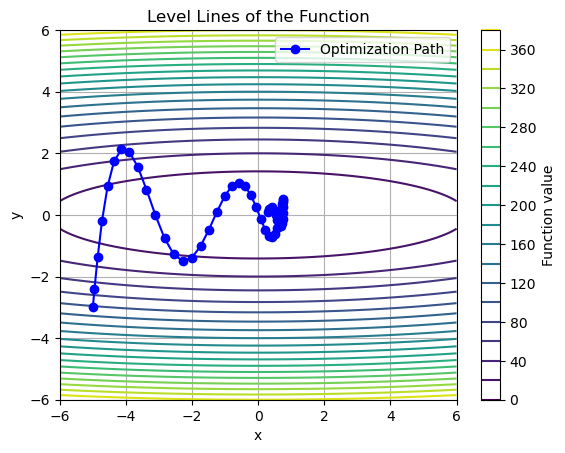

In [49]:
# Check on two-dimensional function
x = torch.tensor([-5.0,-3.0], requires_grad=True)
optimizer = SGDMomentum([x], lr=0.01) # Need to take smaller step size
x_values = optimize_2d(quadratic, x, optimizer)
plot_optimizer_2d(quadratic, x_values)  

## Nesterov Momentum

In ordinary momentum, we take a linear combination of gradient and ema of previous gradients. In Nesterov momentum, we look ahead to the point where the velocity would take us and compute the gradient there.

Mathematically, this is

$$
\begin{aligned}
v^{t+1} & = \rho v^t - \alpha \nabla \mathcal{L}(\theta + \rho v^t) \\
\theta^{t+1} & = \theta^t + v^{t+1}
\end{aligned}
$$

<img src="nesterov-momentum-geometric-illustration.png" alt="Nesterov momentum" width="600"/>

This is not nice to implement, since in our training loop we take the gradient at the current point $\theta^t$. We will use a change of variable.

$$
\tilde{\theta}^t = \theta^t + \rho v^t
$$

This gives the update equation

$$
\begin{aligned}
v^{t+1} & = \rho v^t - \alpha \nabla \mathcal{L}(\tilde{\theta}^{t}) \\
\tilde{\theta}^{t+1} & = \tilde{\theta}^t -\rho v^{t} + (1-\rho) v^{t+1} \\
& = \tilde{\theta}^t + v^{t} + \rho (v^{t+1} - v^t) \\
\end{aligned}
$$

In [50]:
class SGDNesterovMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9, weight_decay=0.0):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v_next = self.momentum * v - self.lr * (param.grad + self.weight_decay * param.data)
            param.add_(v_next + self.momentum * (v_next - v))
            v.set_(v_next)

In [51]:
# Let us try training with the Nesterov Momentum optimizer
model_nesterov = ResNet9(3, 10).to(device)
run_name_nesterov = "Nesterov momentum lr=0.001 wd=0.0001 momentum=0.9"
train_losses_nesterov, val_accs_nesterov, train_accs_nesterov = train(model_nesterov, SGDNesterovMomentum(model_nesterov.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001), num_epochs=15)

Before training: validation accuracy: 0.0936
Epoch 1, Loss: 1.1520592206287374, validation accuracy: 0.6504, train accuracy: 0.68532
Epoch 2, Loss: 0.6843782729816447, validation accuracy: 0.754, train accuracy: 0.82354
Epoch 3, Loss: 0.4640905514478689, validation accuracy: 0.7702, train accuracy: 0.86776
Epoch 4, Loss: 0.30732949922501984, validation accuracy: 0.8175, train accuracy: 0.94572
Epoch 5, Loss: 0.1747624279987813, validation accuracy: 0.8313, train accuracy: 0.98072
Epoch 6, Loss: 0.08230375595211988, validation accuracy: 0.8288, train accuracy: 0.98426
Epoch 7, Loss: 0.03377725127473478, validation accuracy: 0.849, train accuracy: 0.99886
Epoch 8, Loss: 0.011297960690036423, validation accuracy: 0.8545, train accuracy: 0.99996
Epoch 9, Loss: 0.004907999798953531, validation accuracy: 0.8613, train accuracy: 1.0
Epoch 10, Loss: 0.0033523412006348364, validation accuracy: 0.8652, train accuracy: 1.0
Epoch 11, Loss: 0.0026882168528065084, validation accuracy: 0.8661, train 

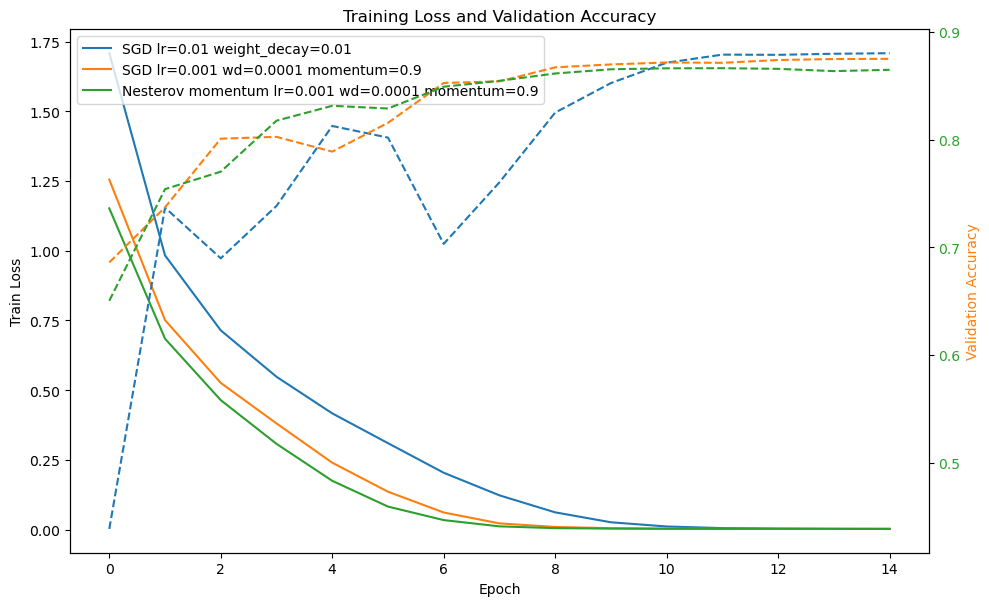

In [52]:
train_losses_list = [train_losses_sgd, train_losses_momentum, train_losses_nesterov]
val_accs_list = [val_accs_sgd, val_accs_momentum, val_accs_nesterov]
run_names = [run_name_sgd, run_name_momentum, run_name_nesterov]
plot_train(train_losses_list, val_accs_list, run_names)

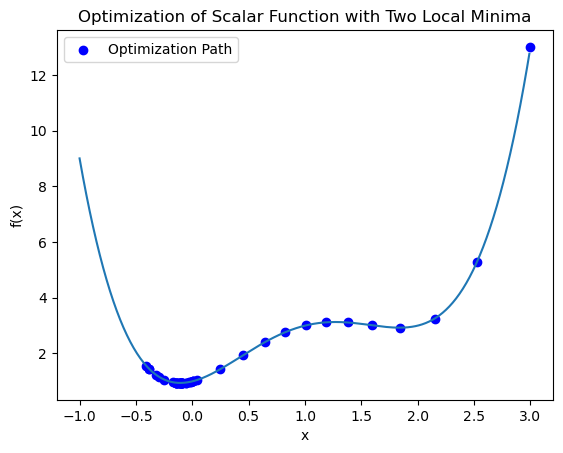

In [53]:
x = torch.tensor([3.0], requires_grad=True)
optimizer = SGDNesterovMomentum([x], lr=0.01, momentum=0.9) # again need smaller learning rate due to momentum
x_values = optimize_1d(poly, x, optimizer)
show_iterations_1d(poly, -1, 3, x_values)

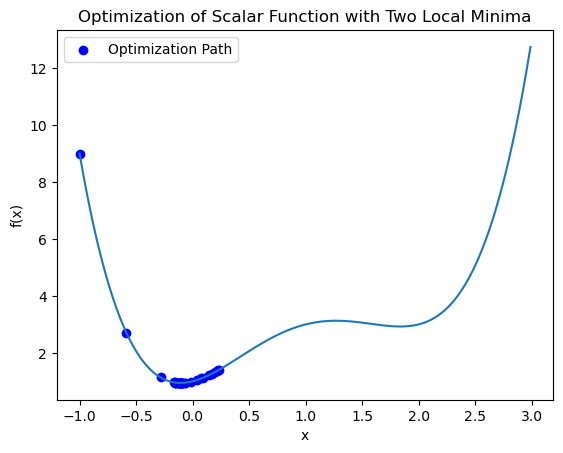

In [54]:
x = torch.tensor([-1.0], requires_grad=True)
optimizer = SGDNesterovMomentum([x], lr=0.01, momentum=0.8)
x_values = optimize_1d(poly, x, optimizer)
show_iterations_1d(poly, -1, 3, x_values)

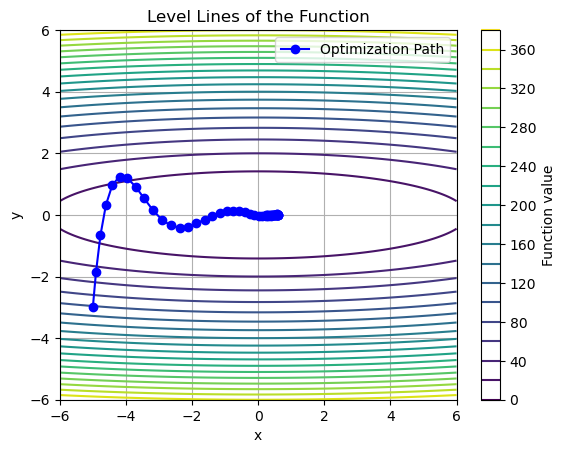

In [55]:
# Check on two-dimensional function
x = torch.tensor([-5.0,-3.0], requires_grad=True)
optimizer = SGDNesterovMomentum([x], lr=0.01) # Need to take smaller step size
x_values = optimize_2d(quadratic, x, optimizer)
plot_optimizer_2d(quadratic, x_values)  

## AdaGrad

High condition number problems can potentially be approached via separate learning rates for each dimension.

- Preconditioning perspective: We have a diagonal matrix by which we scale gradient updates
- Adaptive gradient, per-parameter learning rates: Each weight gets it own learning rate.

In any case we have to compute good learning rates algorithmically, since setting them by hand would be

- impossible for large NNs
- not a good idea since the right learning rate can vary according to the stage of optimization.

AdaGrad = Element-wise scaling of the gradient based on the historical sum of squares in each dimension

$$
\begin{aligned}
g^t & = g^{t-1} + \left(\frac{\partial \mathcal{L}}{\partial \theta}\right)^2 \\
\theta^{t+1} & = \theta^t - \frac{\eta}{\sqrt{g^t} \epsilon} \cdot \frac{\partial \mathcal{L}}{\partial \theta}
\end{aligned}
$$

Pytorch uses $\epsilon = 1e-10$ for stabilizing division.


In [56]:
class Adagrad:
    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10, weight_decay=0.0):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps
        self.weight_decay = weight_decay

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            grad = param.grad + self.weight_decay * param.data
            acc_sqr_grad.add_(grad * grad)
            std = (acc_sqr_grad + self.eps).sqrt()
            param.sub_((self.lr / std) * grad)

In [57]:
# Train ResNet on Cifar with Adagrad

model_adagrad = ResNet9(3, 10).to(device)
run_name_adagrad = f"Adagrad lr=0.01 wd={wd}"
train_losses_adagrad, val_accs_adagrad, train_accs_adagrad = train(model_adagrad, Adagrad(model_adagrad.parameters(), lr=0.01, weight_decay=wd), num_epochs=15)

Before training: validation accuracy: 0.0752
Epoch 1, Loss: 1.2365682544326766, validation accuracy: 0.714, train accuracy: 0.73798
Epoch 2, Loss: 0.6306890127849565, validation accuracy: 0.7215, train accuracy: 0.75884
Epoch 3, Loss: 0.44922504945754976, validation accuracy: 0.8191, train accuracy: 0.8742
Epoch 4, Loss: 0.33439904476165816, validation accuracy: 0.837, train accuracy: 0.91576
Epoch 5, Loss: 0.2445602669751645, validation accuracy: 0.8331, train accuracy: 0.9256
Epoch 6, Loss: 0.17616258455038095, validation accuracy: 0.8524, train accuracy: 0.95784
Epoch 7, Loss: 0.11823527853071691, validation accuracy: 0.8607, train accuracy: 0.9732
Epoch 8, Loss: 0.08275054727613927, validation accuracy: 0.8652, train accuracy: 0.97486
Epoch 9, Loss: 0.05825257003903389, validation accuracy: 0.8494, train accuracy: 0.9663
Epoch 10, Loss: 0.04798879208594558, validation accuracy: 0.8463, train accuracy: 0.97156
Epoch 11, Loss: 0.03632124301865698, validation accuracy: 0.8291, train a

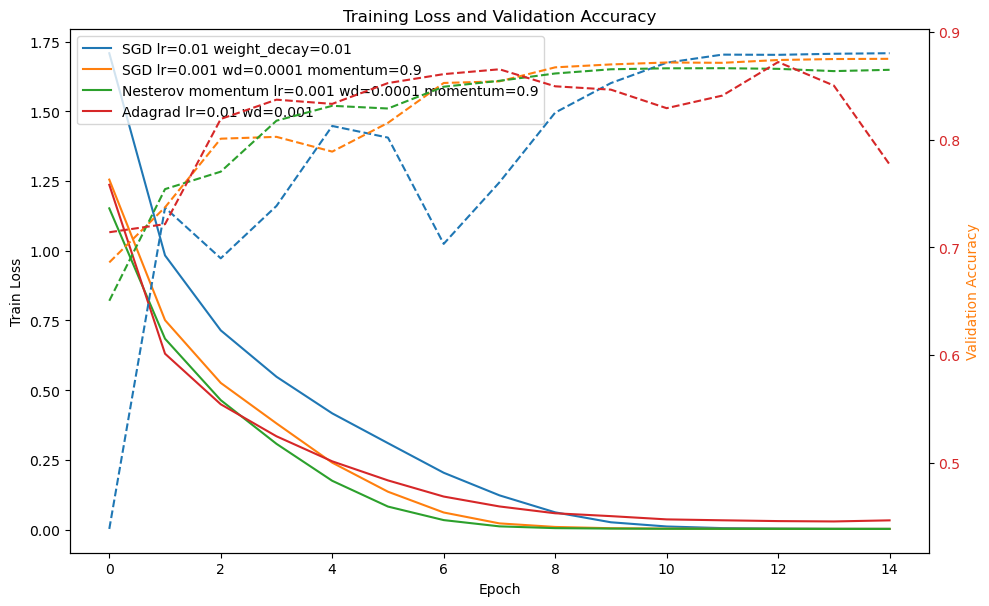

In [58]:
train_losses_list = [train_losses_sgd, train_losses_momentum, train_losses_nesterov, train_losses_adagrad]
val_accs_list = [val_accs_sgd, val_accs_momentum, val_accs_nesterov, val_accs_adagrad]
run_names = [run_name_sgd, run_name_momentum, run_name_nesterov, run_name_adagrad]
plot_train(train_losses_list, val_accs_list, run_names)

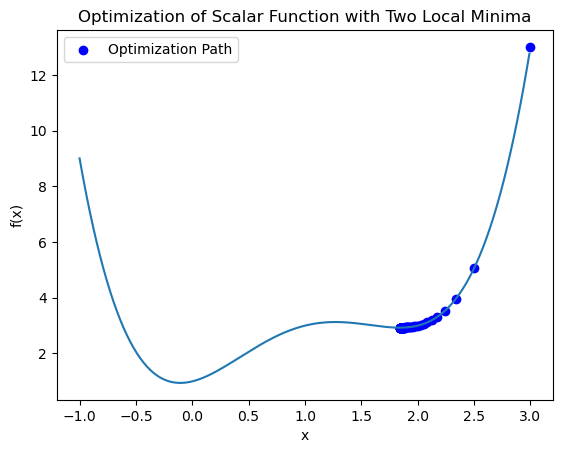

In [59]:
# No momentum, so will get stuck in local minimum

x = torch.tensor([3.0], requires_grad=True)
optimizer = Adagrad([x], lr=0.5) # Need larger learning rate due to normalization
x_values = optimize_1d(poly, x, optimizer)
show_iterations_1d(poly, -1, 3, x_values)

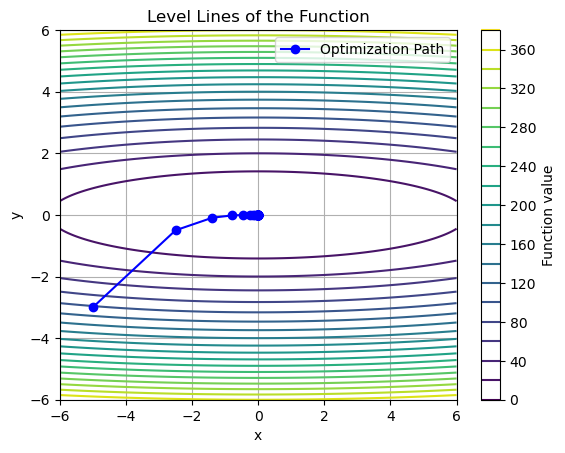

In [60]:
# Check on two-dimensional function: Per-parameter learning gets high condition number under control
x = torch.tensor([-5.0,-3.0], requires_grad=True)
optimizer = Adagrad([x], lr=2.5) # Need to take smaller step size
x_values = optimize_2d(quadratic, x, optimizer)
plot_optimizer_2d(quadratic, x_values)  

## RMSprop

One issue with Adagrad is that the gradient history $g^t$ is monotonically increasing.

RMSprop replaces the gradient history with an exponential moving average, thereby "forgetting"  old gradients that are not helpful for the gradient history anymore.
The gradient history update becomes
$$
g^t = \rho \cdot g^{t-1} + (1-\rho) \cdot \left(\frac{\partial \mathcal{L}}{\partial \theta}\right)^2 
$$

The overall update scheme becomes

$$
\begin{aligned}
g^t & = \rho \cdot g^{t-1} + (1-\rho) \cdot \left(\frac{\partial \mathcal{L}}{\partial \theta}\right)^2 \\
\theta^{t+1} & = \theta^t - \eta \cdot \frac{1}{\sqrt{g^t+\epsilon}} \cdot \frac{\partial \mathcal{L}}{\partial \theta}\\
\end{aligned}
$$

In [61]:
class RMSprop:
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

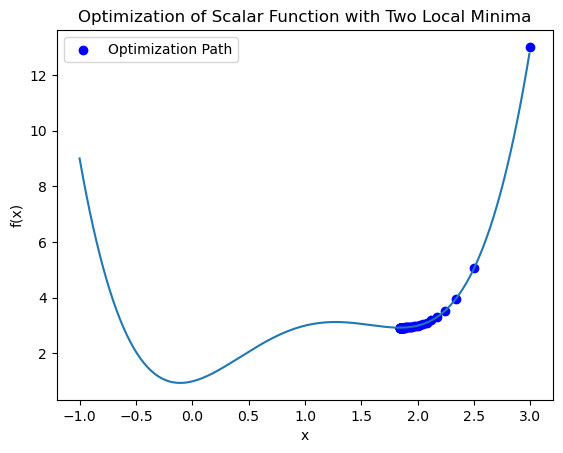

In [62]:
# No momentum, so will get stuck in local minimum

x = torch.tensor([3.0], requires_grad=True)
optimizer = RMSprop([x], lr=0.05) # Need smaller learning rate than Adagrad due to smaller normalization
x_values = optimize_1d(poly, x, optimizer)
show_iterations_1d(poly, -1, 3, x_values)

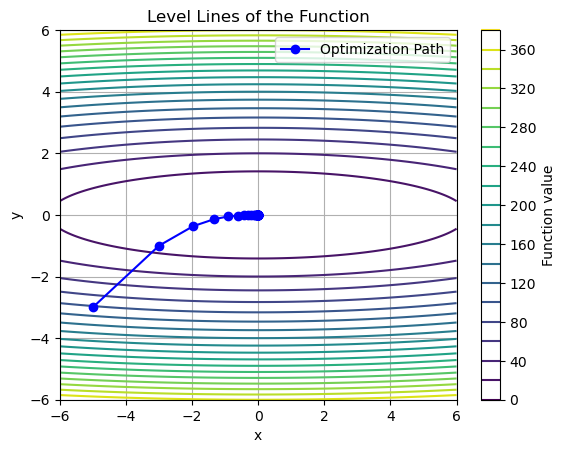

In [63]:
# Check on two-dimensional function: Per-parameter learning gets high condition number under control
x = torch.tensor([-5.0,-3.0], requires_grad=True)
optimizer = Adagrad([x], lr=2) # Need to take smaller step size
x_values = optimize_2d(quadratic, x, optimizer)
plot_optimizer_2d(quadratic, x_values)

## Adadelta = first try to get normalization on step size

Right now, optimizing $\mathcal{L}$ with learning rate $\alpha$ is equivalent to optimizing $\gamma \cdot \mathcal{L}$ with step size $\gamma \cdot \alpha$.
Our optimizer is in particular not scale-invariant.
Subsequently, we will use additional normalization to solve this issue.

Adadelta remembers an exponential moving average on the parameter updates to normalize the gradient update.
$$
\delta^{t+1} = \rho \cdot \delta^{t-1} + (1-\rho) \left( \theta^{t+1} - \theta^t \right)^2
$$

The final update step pre-conditions the gradient update step by $\frac{\sqrt{\delta}}{\sqrt{g}}$

This allows Adadelta to significantly reduce the importance of choosing the right step size. Since we scale by the gradient magnitude, we do not have to adapt the learning rate to different scales of the loss function. I.e. in Adadelta we can take the same learning rate $\eta$ for minimizing $\mathcal{L}$ and $C \cdot \mathcal{L}$ for any $C \in \R_+$.


In symmary, Adadelta works as follows: 
- Squared gradient EMA history update,
- Normalized gradient step: (parameter history EMA) / (gradient history EMA) * gradient
- Squared parameter EMA history update

$$
\begin{aligned}
g^t & = \rho \cdot g^{t-1} + (1-\rho) \cdot \left(\frac{\partial \mathcal{L}}{\partial \theta}\right)^2 \\
\theta^{t+1} & = \theta^t - \eta \cdot \frac{\sqrt{\delta^t + \epsilon}}{\sqrt{g^t+\epsilon}} \cdot \frac{\partial \mathcal{L}}{\partial \theta}\\
\delta^{t+1} & = \rho \cdot \delta^{t-1} + (1-\rho) \left( \theta^{t+1} - \theta^t \right)^2
\end{aligned}
$$

Note that the $\epsilon$ is used in the square root and also both in nominator and denominator.
Pytorch uses a default value of $1e-6$.

In [64]:
class Adadelta:
    def __init__(self, model_params, rho=0.9, eps=1e-6, weight_decay=0.0):
        self.model_params = list(model_params)
        #self.lr = lr
        self.rho = rho
        self.eps = eps
        self.weight_decay = weight_decay
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params] 

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params, self.avg_sqr_grads, self.avg_sqr_deltas):
            grad = param.grad + self.weight_decay * param.data

            avg_sqr_grad.mul_(self.rho)
            avg_sqr_grad.add_((1 - self.rho) * (grad ** 2))

            delta = (avg_sqr_delta + self.eps).sqrt() / (avg_sqr_grad + self.eps).sqrt() * grad
            param.sub_(delta)

            avg_sqr_delta.mul_(self.rho)
            avg_sqr_delta.add_((1 - self.rho) * delta ** 2)

In [65]:
# try out Adadelta:
model_adadelta = ResNet9(3, 10).to(device)
run_name_adadelta = f"Adadelta rho=0.9 wd={wd}"
train_losses_adadelta, val_accs_adadelta, train_accs_adadelta = train(model_adadelta, Adadelta(model_adadelta.parameters(), weight_decay=wd), num_epochs=15)

Before training: validation accuracy: 0.1
Epoch 1, Loss: 1.566153096199038, validation accuracy: 0.4612, train accuracy: 0.46582
Epoch 2, Loss: 0.8546199581527704, validation accuracy: 0.5083, train accuracy: 0.51536
Epoch 3, Loss: 0.6826338610935211, validation accuracy: 0.6955, train accuracy: 0.72686
Epoch 4, Loss: 0.6178762329483027, validation accuracy: 0.7345, train accuracy: 0.75876
Epoch 5, Loss: 0.5802072039127356, validation accuracy: 0.6899, train accuracy: 0.71954
Epoch 6, Loss: 0.5535575626659399, validation accuracy: 0.6821, train accuracy: 0.71522
Epoch 7, Loss: 0.5359013914346693, validation accuracy: 0.7777, train accuracy: 0.8152
Epoch 8, Loss: 0.5244324767017369, validation accuracy: 0.7885, train accuracy: 0.83448
Epoch 9, Loss: 0.5139934931278232, validation accuracy: 0.7431, train accuracy: 0.78016
Epoch 10, Loss: 0.5039753480243684, validation accuracy: 0.7918, train accuracy: 0.83794
Epoch 11, Loss: 0.4913302413749701, validation accuracy: 0.7962, train accuracy

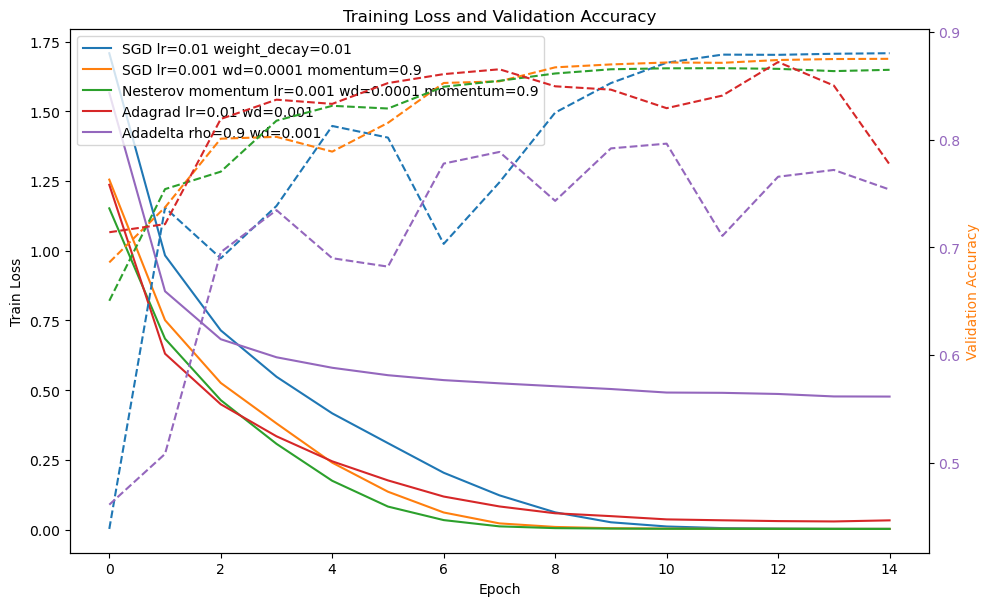

In [66]:
train_losses_list = [train_losses_sgd, train_losses_momentum, train_losses_nesterov, train_losses_adagrad, train_losses_adadelta]
val_accs_list = [val_accs_sgd, val_accs_momentum, val_accs_nesterov, val_accs_adagrad, val_accs_adadelta]
run_names = [run_name_sgd, run_name_momentum, run_name_nesterov, run_name_adagrad, run_name_adadelta]
plot_train(train_losses_list, val_accs_list, run_names)

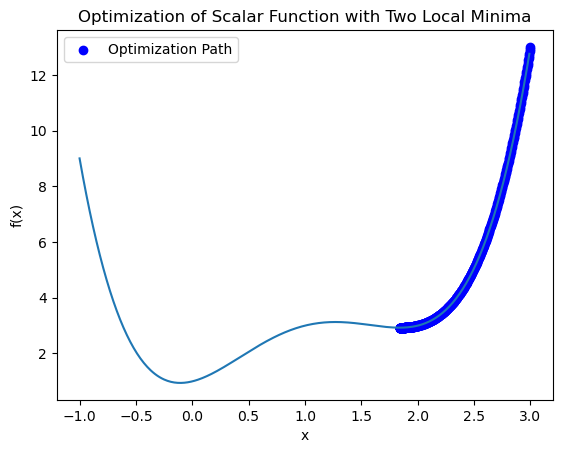

In [67]:
x = torch.tensor([3.0], requires_grad=True)
optimizer = Adadelta([x], rho=0.9) # Need smaller learning rate than Adagrad due to smaller normalization
x_values = optimize_1d(poly, x, optimizer, nr_steps=500)
show_iterations_1d(poly, -1, 3, x_values)

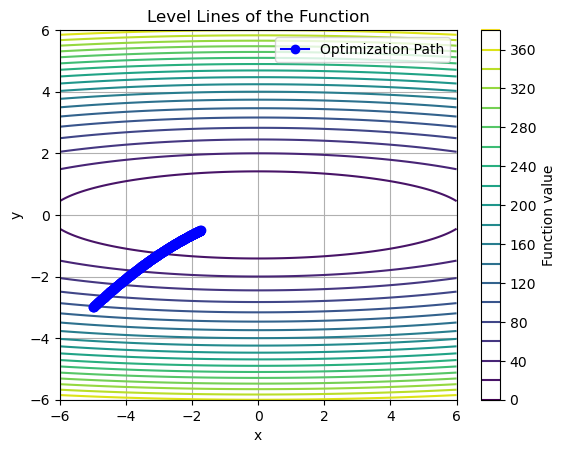

In [68]:
# Check on two-dimensional function: Per-parameter learning gets high condition number under control
x = torch.tensor([-5.0,-3.0], requires_grad=True)
optimizer = Adadelta([x], rho=0.99)
x_values = optimize_2d(quadratic, x, optimizer, nr_steps=500)
plot_optimizer_2d(quadratic, x_values)

## AdamW = RMSProp + Momentum + proper handling of weight decay

Adam differs from Adadelta in that it does not use EMA of squared parameter changes but a momentum, i.e. an EMA on the gradient. Hence, it combines RMSProp normalization and SGD momentum.

This gives the preliminary Adam as follows:

$$
\begin{aligned}
m^t & = \beta_1 m^{t-1} + (1-\beta_1) \frac{\partial \mathcal{L}}{\partial \theta} \\
g^t & = \beta_2 \cdot g^{t-1} + (1-\beta_2) \cdot \left(\frac{\partial \mathcal{L}}{\partial \theta}\right)^2 \\
\theta^{t+1} = \theta^t - \eta \frac{m^t}{\sqrt{g^t} + \epsilon}
\end{aligned}
$$

$m$ is also called the first momentum and $g$ the second one.

- Adams momentum $m$ corresponds to the momentum $v$ in SGD with momentum.
- We initialize $m$ and $g$ to zero.
- $\beta_1$ and $\beta_2$ are by default close to one. Pytorch sets $\beta_1 = 0.9$ and $\beta_2 = 0.99$ by default.
- Popular learning rates $\eta$ are $\{1e-3, 5e-4, 1e-4\}$
- $\epsilon$ is chosed as $1e-7$ by default in pytorch.

Similarly as in Adadelta, the importance of the learning rate does not depend on the scale of the loss function, thereby making finding a good learning rate much easier.

**Bias correction**: The only remaining problem is that in the beginning estimates for for $m$ and $g$ start at zero and remain there due to EMA.
Hence, Adam additionally computes a bias correction term.

$$
\begin{aligned}
m^t & = \beta_1 m^{t-1} + (1-\beta_1) \frac{\partial \mathcal{L}}{\partial \theta} \\
g^t & = \beta_2 \cdot g^{t-1} + (1-\beta_2) \cdot \left(\frac{\partial \mathcal{L}}{\partial \theta}\right)^2 \\
\tilde{m}^t & = m^t / (1-\beta_1^t) \\
\tilde{g}^t & = g^t / (1-\beta_2^t) \\
\theta^{t+1} & = \theta^t - \eta \frac{\tilde{m}^t}{\sqrt{\tilde{g}^t} + \epsilon}
\end{aligned}
$$


In [69]:
class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.n_steps = 0
        
    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_grad, avg_sqr_grad in zip(self.model_params, \
                                                 self.avg_grads, \
                                                 self.avg_sqr_grads):
            self.n_steps += 1
            grad = param.grad + self.weight_decay * param.data
            avg_grad.mul_(self.beta_1).add_(grad * (1 - self.beta_1))
            avg_sqr_grad.mul_(self.beta_2).add_(grad * grad * (1 - self.beta_2))
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)
            param.sub_(self.lr * avg_grad_corrected / std)

## AdamW

AdamW is Adam but the weight decay does not affect the other terms. That is, we do not add the weight decay to the loss term but handle it explicitly only in the update step for $\theta$ but neither for the momentum $m^t$ nor for the gradient history $g^t$.

$$
\begin{aligned}
m^t & = \beta_1 m^{t-1} + (1-\beta_1) \frac{\partial \mathcal{L}}{\partial \theta} \\
g^t & = \beta_2 \cdot g^{t-1} + (1-\beta_2) \cdot \left(\frac{\partial \mathcal{L}}{\partial \theta}\right)^2 \\
\tilde{m}^t & = m^t / (1-\beta_1^t) \\
\tilde{g}^t & = g^t / (1-\beta_2^t) \\
\theta^{t+1} & = \theta^t - \eta \frac{\tilde{m}^t}{\sqrt{\tilde{g}^t} + \epsilon} + \lambda \cdot \theta^t
\end{aligned}
$$

Typically, AdamW gives better results than Adam.


In [70]:
class AdamW:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.00):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.n_steps = 0
        self.weight_decay = weight_decay
        
    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_grad, avg_sqr_grad in zip(self.model_params, \
                                                 self.avg_grads, \
                                                 self.avg_sqr_grads):
            self.n_steps += 1
            grad = param.grad
            avg_grad.mul_(self.beta_1).add_(grad * (1 - self.beta_1))
            avg_sqr_grad.mul_(self.beta_2).add_(grad * grad * (1 - self.beta_2))
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)
            param.sub_(self.lr * (avg_grad_corrected / std + self.weight_decay * param.data))

### Second Momentum

Often, the squared gradient history is also referred to as the second moment, or $m_2^t$.

In [ ]:
# Let us try Adam:
model_adamw = ResNet9(3, 10).to(device)
run_name_adamw = f"AdamW lr=0.0002 wd={wd}"
train_losses_adamw, val_accs_adamw, train_accs_adamw = train(model_adamw, AdamW(model_adamw.parameters(), lr=0.0002, weight_decay=0.1*wd), num_epochs=15)

Before training: validation accuracy: 0.1
Epoch 1, Loss: 0.9547322034454345, validation accuracy: 0.7633, train accuracy: 0.79966
Epoch 2, Loss: 0.5294050131034852, validation accuracy: 0.8088, train accuracy: 0.86998
Epoch 3, Loss: 0.37373225137710586, validation accuracy: 0.8304, train accuracy: 0.91884
Epoch 4, Loss: 0.2518238026046757, validation accuracy: 0.8387, train accuracy: 0.93854
Epoch 5, Loss: 0.16085489845335468, validation accuracy: 0.8552, train accuracy: 0.97406
Epoch 6, Loss: 0.09961459496855728, validation accuracy: 0.8429, train accuracy: 0.96264
Epoch 7, Loss: 0.07172859017550937, validation accuracy: 0.8568, train accuracy: 0.98534
Epoch 8, Loss: 0.053548767490685, validation accuracy: 0.8527, train accuracy: 0.98442
Epoch 9, Loss: 0.04376665090210734, validation accuracy: 0.8496, train accuracy: 0.98418
Epoch 10, Loss: 0.03833903527557846, validation accuracy: 0.8401, train accuracy: 0.97598
Epoch 11, Loss: 0.030337124707922377, validation accuracy: 0.8483, train

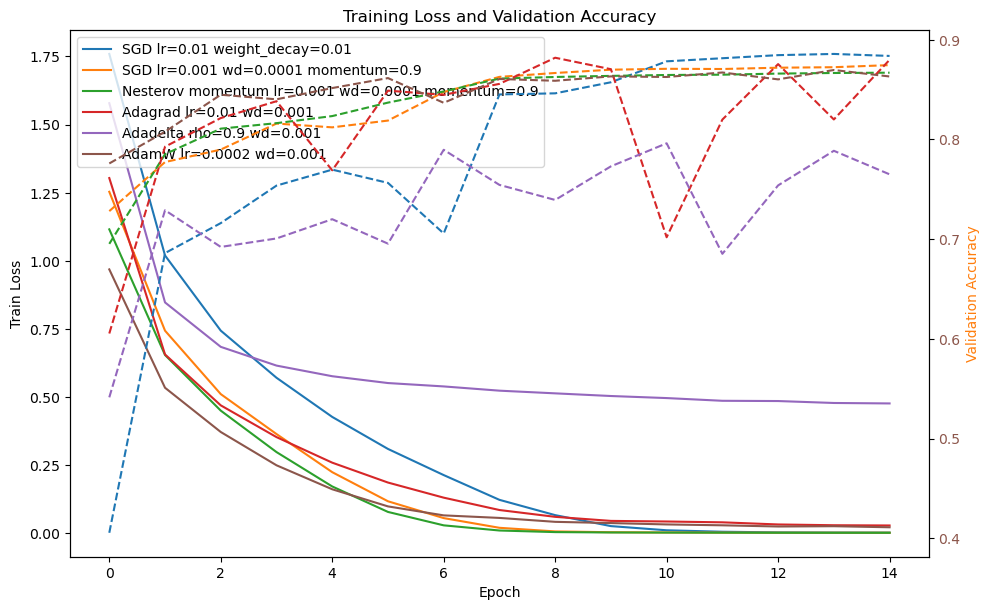

In [ ]:
train_losses_list = [train_losses_sgd, train_losses_momentum, train_losses_nesterov, train_losses_adagrad, train_losses_adadelta, train_losses_adamw]
val_accs_list = [val_accs_sgd, val_accs_momentum, val_accs_nesterov, val_accs_adagrad, val_accs_adadelta, val_accs_adamw]
run_names = [run_name_sgd, run_name_momentum, run_name_nesterov, run_name_adagrad, run_name_adadelta, run_name_adamw]
plot_train(train_losses_list, val_accs_list, run_names)

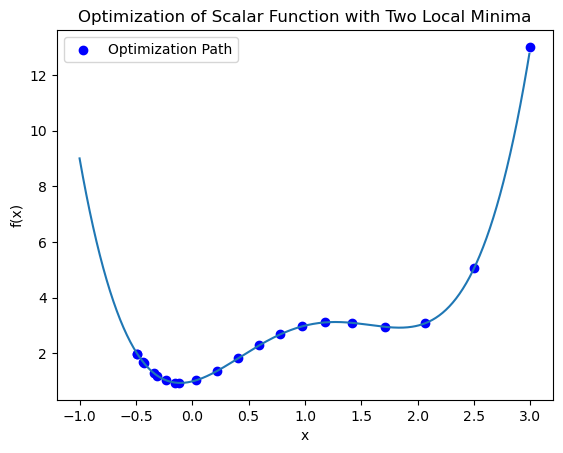

In [ ]:
x = torch.tensor([3.0], requires_grad=True)
optimizer = AdamW([x], lr=0.5) # Need smaller learning rate than Adagrad due to smaller normalization
x_values = optimize_1d(poly, x, optimizer, nr_steps=20)
show_iterations_1d(poly, -1, 3, x_values)

## Conclusion Optimization Algorithms:

- SGD is easy to beat.
- Adam has become the most popular gradient descent algorithm due to its stability and effectiveness. It is a good default choice and does not need so much tuning.
- SGD + momentum sometimes beats Adam with careful tuning.
- RMSProp is popular in reinforcement learning.

From now on we will use the pytorch implementations of the respective optimization algorithms and will sue Adam by default.

# Learning rate schedules

Typically learning in the beginning is easier: We can make big steps and get fast improvement. Small differences in weights do not matter much.

Typically learning not far from a good point is more delicate: Overshooting occurs easily. Small differences in weights start to matter.

Therefore, learning rate schedules are used.

## Step Decay

In [ ]:
class StepDecayScheduler:
    def __init__(self, optimizer, initial_lr, decay_factor, step_size):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.decay_factor = decay_factor
        self.step_size = step_size
    
    def get_lr(self, epoch):
        return self.initial_lr * (self.decay_factor ** np.floor((1+epoch)/self.step_size))

    def step(self, epoch):
        lr = self.get_lr(epoch)
        self.optimizer.lr = lr
        self.optimizer.step()

In [ ]:
# function for plotting the learning rate schedule
def plot_lr_schedule(lr_scheduler, num_epochs):
    lrs = [lr_scheduler.get_lr(epoch) for epoch in range(num_epochs)]
    plt.plot(lrs)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)

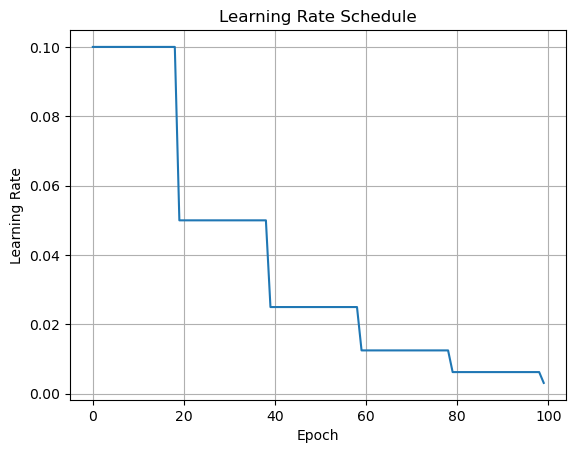

In [ ]:
plot_lr_schedule(StepDecayScheduler(None, 0.1, 0.5, 20), 100)

Often, we will see a sudden improvement in training loss and accuracy after each learning rate drop.

## Exponential Decay

In [ ]:
class ExpDecayScheduler:
    def __init__(self, optimizer, initial_lr, decay_rate):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        
    def get_lr(self, epoch):
        return self.initial_lr * math.exp(-self.decay_rate * epoch)

    def step(self, epoch):
        lr = self.get_lr(epoch)
        self.optimizer.lr = lr
        self.optimizer.step()

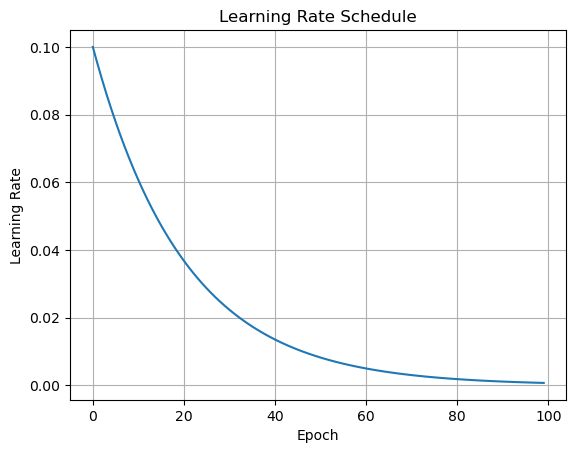

In [ ]:
plot_lr_schedule(ExpDecayScheduler(None, 0.1, 0.05), 100)

## Cosine Annealing

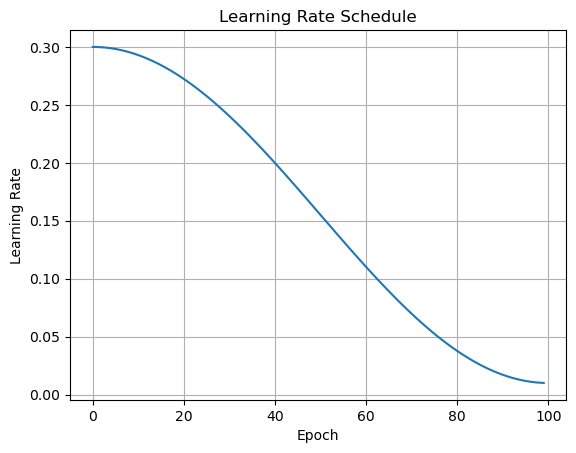

In [ ]:
class CosineScheduler:
    def __init__(self, optimizer, max_epochs, lr_max=0.01, lr_min=0):
        self.optimizer = optimizer
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.max_epochs = max_epochs

    def get_lr(self, epoch):
        return self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (1 + np.cos(epoch / self.max_epochs * np.pi))

    def step(self, epoch):
        lr = self.get_lr(epoch)
        self.optimizer.lr = lr
        self.optimizer.step()

scheduler = CosineScheduler(None, max_epochs=100, lr_max=0.3, lr_min=0.01)
plot_lr_schedule(scheduler, 100)

## Warmup

In warmup we choose a small learning rate for a few iterations at the beginning and then continue with our ordinary learning rate schedule.

In [ ]:
class WarmupScheduler:
    def __init__(self, base_scheduler, warmup_epochs):
        self.base_scheduler = base_scheduler
        self.warmup_epochs = warmup_epochs

    def get_lr(self, epoch):
        if epoch < self.warmup_epochs:
            return self.base_scheduler.get_lr(0) * (epoch + 1) / self.warmup_epochs
        return self.base_scheduler.get_lr(epoch-self.warmup_epochs)

    def step(self, epoch):
        lr = self.get_lr(epoch)
        self.base_scheduler.optimizer.lr = lr
        self.base_scheduler.optimizer.step()

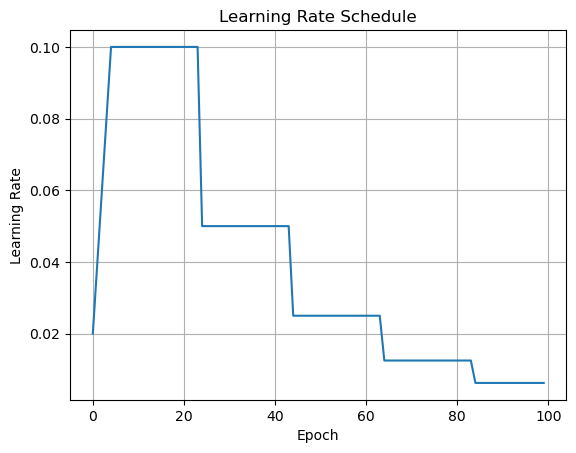

In [ ]:
warmup_step_decay = WarmupScheduler(StepDecayScheduler(None, 0.1, 0.5, 20), 5)
plot_lr_schedule(warmup_step_decay, 100)

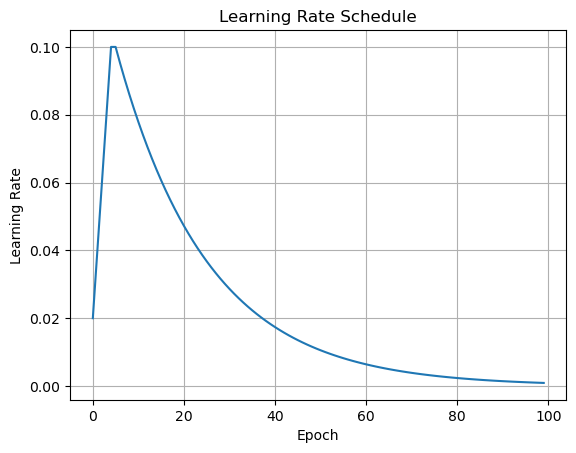

In [ ]:
warmup_exp_decay = WarmupScheduler(ExpDecayScheduler(None,0.1, 0.05), 5)
plot_lr_schedule(warmup_exp_decay, 100)

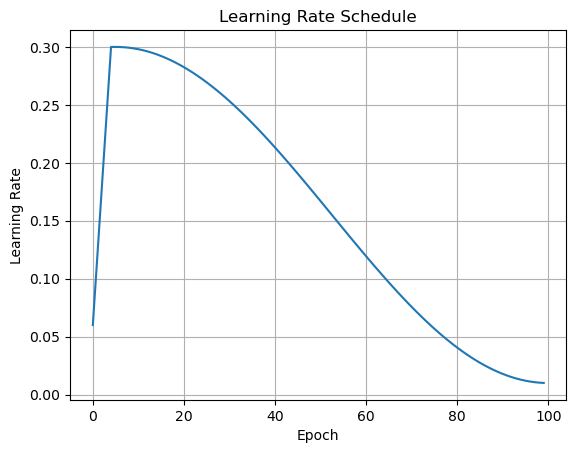

In [ ]:
warmup_cosine_annealing = WarmupScheduler(CosineScheduler(None, max_epochs=100-5, lr_max=0.3, lr_min=0.01), 5)
plot_lr_schedule(warmup_cosine_annealing, 100)

### Reasons for using warmup are:

- For use with optimizers that compute EMA-based statistics. Since they need to be initialized before giving any benefit, it makes sense to first make little steps that nevertheless initialize the statistics to good values.
- To avoid early overfitting: Sometimes, when using very large steps and sampling correlated batches, we might end up in a parameter region that will not generalize well and from which escaping will be difficult.

In [ ]:
def train(model, optimizer, scheduler, num_epochs=10):
    val_acc = validate(model, testloader)
    train_acc = validate(model, trainloader)
    model.train()
    print(f"Before training: validation accuracy: {val_acc}")

    # Training loop
    losses = []
    val_accs = []
    train_accs = []

    for epoch in range(num_epochs):
        loss = 0.0
        
        model.train()
        for data, target in trainloader:
            data = data.to(device)
            target = target.to(device)
            # Forward pass
            preds = model(data)
            
            # Loss calculation
            mb_loss = mb_loss = F.cross_entropy(preds, target=target)
            loss += mb_loss.item() * data.shape[0] / len(trainloader.dataset)

            ### ZERO GRAD ###
            optimizer.zero_grad()
            # backward pass
            mb_loss.backward()
        
            # The weight update
            scheduler.step(epoch)

        losses.append(loss)
        val_acc = validate(model, testloader)
        val_accs.append(val_acc)
        train_acc = validate(model, trainloader)
        model.train()
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, Loss: {loss}, validation accuracy: {val_acc}, train accuracy: {train_acc}")

    return losses, val_accs, train_accs 

# Training with everything

We will use warmup, cosine annealing and AdamW with some reasonable parameters for training.

In [ ]:
model_adamw_lrs = ResNet9(3, 10).to(device)
wd = 0.0001
run_name_adamw_lrs = f"AdamW lr=[0.000001,0.0003] wd={wd} cosine+warmup"
optimizer = AdamW(model_adamw_lrs.parameters(), lr=0.01, weight_decay=wd)
warmup_cosine_annealing = WarmupScheduler(CosineScheduler(optimizer=optimizer, max_epochs=15-2, lr_max=0.0003, lr_min=0.000001), 2)
train_losses_adamw_lrs, val_accs_adamw_lrs, train_accs_adamw_lrs = train(model_adamw_lrs, optimizer, warmup_cosine_annealing, num_epochs=15)

In [ ]:
train_losses_list = [train_losses_sgd, train_losses_momentum, train_losses_nesterov, train_losses_adagrad, train_losses_adadelta, train_losses_adamw, train_losses_adamw_lrs]
val_accs_list = [val_accs_sgd, val_accs_momentum, val_accs_nesterov, val_accs_adagrad, val_accs_adadelta, val_accs_adamw, val_accs_adamw_lrs]
run_names = [run_name_sgd, run_name_momentum, run_name_nesterov, run_name_adagrad, run_name_adadelta, run_name_adamw, run_name_adamw_lrs]
plot_train(train_losses_list, val_accs_list, run_names)

# Conclusion 

We now have all tools to train neural networks efficiently in practice, i.e.

- normalization
- residual connections
- regularization
- augmentation
- better optimization algorithms and learning rate schedules

We have gone from cumbersome, unstable, fragile training to more robust, fast, scalable and more easily tunable training.